In [10]:
import pandas as pd
import spacy
from sklearn.metrics import make_scorer, classification_report, make_scorer, recall_score, f1_score, accuracy_score, confusion_matrix
import time
import seaborn as sns
import matplotlib.pyplot as plt


train = pd.read_csv("../data/avis/train_noYC_lemma_sent_equil.csv", index_col= 0)
df = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx')

nlp = spacy.load("fr_core_news_lg")

In [12]:
df.head()

,user,etoiles,n_avis,date_avis,titre_avis,text_avis,codes agrégés,comment,var_frais,var_efficacité,var_efficacité_bad,var_efficacité_good,var_discrimination,var_protection,var_clôture,var_prêts,var_virements,var_communication
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,1,NaN,NaN,NaN,NaN,NaN,NaN
1,Sylvain Andujar,3.0,3.0,2022-07-26 10:10:19,Pour l'instant toujours en attente,"Pour l'instant toujours en attente, tout les j...",bad:inefficace,NaN,NaN,bad:inefficace,1,0,0,NaN,NaN,NaN,NaN,NaN
2,ANNICK JALLET,3.0,1.0,2022-04-11 14:14:30,intérêts trop élevés,na,na,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,Client,2.0,3.0,2023-06-07 16:57:39,"C'était les meilleurs, mais c'était avant",Deux dernières fois où j'ai dû faire appel à F...,bad:communication; bad:inefficace,NaN,NaN,bad:inefficace,1,0,0,NaN,NaN,NaN,NaN,bad:communication
4,Radio Anime,1.0,1.0,2023-09-08 13:30:04,Vous n'aidez pas les gens,"Vous n'aidez pas les gens, vous faites l'inver...",na,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
theme_frais= [row['text_avis'] for index, row in df.iterrows() if pd.notna(row['var_frais'])]
theme_efficacite = [row['text_avis'] for index, row in df.iterrows() if pd.notna(row['var_efficacité'])]
theme_discrimination = [row['text_avis'] for index, row in df.iterrows() if pd.notna(row['var_discrimination'])]
theme_protexction = [row['text_avis'] for index, row in df.iterrows() if pd.notna(row['var_protection'])]
theme_cloture = [row['text_avis'] for index, row in df.iterrows() if pd.notna(row['var_clôture'])]
theme_prets = [row['text_avis'] for index, row in df.iterrows() if pd.notna(row['var_prêts'])]
theme_virements = [row['text_avis'] for index, row in df.iterrows() if pd.notna(row['var_virements'])]
theme_communication = [row['text_avis'] for index, row in df.iterrows() if pd.notna(row['var_communication'])]

nuggets_efficacité = pd.read_excel("../data/avis/general_df_clean_sent_15k_manual_code.xlsx",
                                   sheet_name = "curation_efficacité", index_col= 0)

# efficace 
list_exemples_efficace = nuggets_efficacité.curated_efficace
list_exemples_efficace = list_exemples_efficace.dropna()
bag_efficace = " ".join([message for message in list_exemples_efficace])
bag_efficace_nlp = nlp(bag_efficace)

# innefficace
list_exemples_innefficace = nuggets_efficacité.curated_inneficace
list_exemples_innefficace = list_exemples_innefficace.dropna()
bag_innefficace = " ".join([message for message in list_exemples_innefficace])
bag_innefficace_nlp =nlp(bag_innefficace)

nuggets_efficacité.head(1)

,raw_efficacité_efficace,curated_efficace,raw_ineficace,curated_inneficace
NaN,"Je suis satisfaite de l'accueil,du suivi merc...","Je suis satisfaite de l'accueil,du suivi merc...",délai trop long entre dossier et réception arg...,délai trop long entre dossier et réception arg...


In [3]:
def label_banks(df,ref_bag,lab_col,thresh = 0.83):
    y_pred = []
    round_count = 0
    t0 = time.time() # initialising empty variables and the timer
    for message in df.text_total: # for each review
        round_count+=1
        sim_score= []
        message = nlp(message)
        for unlabeled_sentence in message.sents: # for every sentence in the review
            for labeled_sentence in ref_bag.sents : # for every sentence in our reference bag of labeled reviews
                temp_sim_score = round(labeled_sentence.similarity(unlabeled_sentence),2) # check similarity between review sentence <> reference sentence
                sim_score.append(temp_sim_score)
        if max(sim_score) > thresh:
            y_pred.append(1)
        else:
            y_pred.append(0)
        if round_count % 100 == 0: # notification every 100 passed review
            print(round_count, " messages labelled")
    t1 = time.time() # stopping the timer
    delais = round((t1-t0)/60,2)
    df[lab_col] = y_pred # integrating result in our source dataframe
    print(f"{delais} minutes to compete similarity labelling")
    df[lab_col].value_counts()

In [4]:
# predicting not efficacious banking services
y_pred = []
label_banks(train,bag_innefficace_nlp,"var_efficacité_bad",0.83)

/var/folders/7m/gxswx1js22x0hszgmzpd29qcg1657r/T/ipykernel_5098/3635321684.py:11: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  temp_sim_score = round(labeled_sentence.similarity(unlabeled_sentence),2) # check similarity between review sentence <> reference sentence


100  messages labelled
200  messages labelled
300  messages labelled
400  messages labelled
500  messages labelled
600  messages labelled
700  messages labelled
800  messages labelled
900  messages labelled
1000  messages labelled
1100  messages labelled
1200  messages labelled
1300  messages labelled
1400  messages labelled
1500  messages labelled
1600  messages labelled
1700  messages labelled
1800  messages labelled
1900  messages labelled
2000  messages labelled
2100  messages labelled
2200  messages labelled
2300  messages labelled
2400  messages labelled
2500  messages labelled
2600  messages labelled
2700  messages labelled
2800  messages labelled
2900  messages labelled
3000  messages labelled
3100  messages labelled
3200  messages labelled
3300  messages labelled
3400  messages labelled
3500  messages labelled
3600  messages labelled
3700  messages labelled
3800  messages labelled
3900  messages labelled
4000  messages labelled
4100  messages labelled
4200  messages labelled
4

Visualisation messages labelisés comme services efficaces vs le reste 

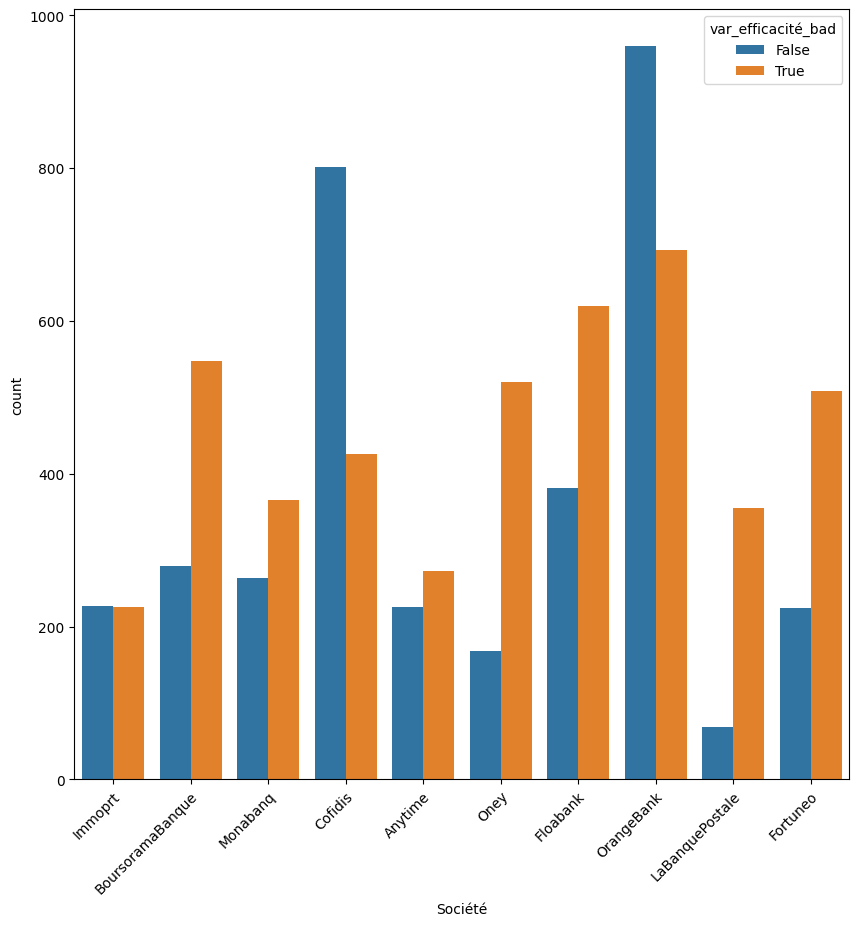

In [5]:
# top_bank topbank
list_top = [bank for bank in train.Société.value_counts().keys()[0:10]]
train_top = train[train['Société'].isin(list_top)]

import seaborn as sns
plt.figure(figsize=(10,10))
ax =sns.countplot(x = train_top.Société, hue = train_top['var_efficacité_bad']== 1)
plt.xticks(rotation=45, ha = 'right', rotation_mode = "anchor");
plt.show()

Labelisation des messages "services inefficaces"

In [6]:
# predicting efficacious banking services
y_pred = []
label_banks(train,bag_efficace_nlp,"var_efficacité_good",0.83)


/var/folders/7m/gxswx1js22x0hszgmzpd29qcg1657r/T/ipykernel_5098/3635321684.py:11: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  temp_sim_score = round(labeled_sentence.similarity(unlabeled_sentence),2) # check similarity between review sentence <> reference sentence


100  messages labelled
200  messages labelled
300  messages labelled
400  messages labelled
500  messages labelled
600  messages labelled
700  messages labelled
800  messages labelled
900  messages labelled
1000  messages labelled
1100  messages labelled
1200  messages labelled
1300  messages labelled
1400  messages labelled
1500  messages labelled
1600  messages labelled
1700  messages labelled
1800  messages labelled
1900  messages labelled
2000  messages labelled
2100  messages labelled
2200  messages labelled
2300  messages labelled
2400  messages labelled
2500  messages labelled
2600  messages labelled
2700  messages labelled
2800  messages labelled
2900  messages labelled
3000  messages labelled
3100  messages labelled
3200  messages labelled
3300  messages labelled
3400  messages labelled
3500  messages labelled
3600  messages labelled
3700  messages labelled
3800  messages labelled
3900  messages labelled
4000  messages labelled
4100  messages labelled
4200  messages labelled
4

In [7]:
conso = []
train["conso_efficacité"] = ''
for i, message in enumerate(train.var_efficacité_good):
    if train.var_efficacité_good.iloc[i] == 1 and train.var_efficacité_bad.iloc[i] == 0:
        train["conso_efficacité"].iloc[i] = "efficace"
    elif train.var_efficacité_good.iloc[i] == 0 and train.var_efficacité_bad.iloc[i] == 1:
        train["conso_efficacité"].iloc[i] = "inefficace"
    elif train.var_efficacité_good.iloc[i] == 1 and train.var_efficacité_bad.iloc[i] == 1:
        train["conso_efficacité"].iloc[i] = "mitigé"
    elif train.var_efficacité_good.iloc[i] == 0 and train.var_efficacité_bad.iloc[i] == 0:
        train["conso_efficacité"].iloc[i] =  "not discussed"
    else:
        train["conso_efficacité"].iloc[i] = "na"

train["conso_efficacité"].value_counts()

/var/folders/7m/gxswx1js22x0hszgmzpd29qcg1657r/T/ipykernel_5098/157693706.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["conso_efficacité"].iloc[i] =  "not discussed"
/var/folders/7m/gxswx1js22x0hszgmzpd29qcg1657r/T/ipykernel_5098/157693706.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["conso_efficacité"].iloc[i] = "efficace"
/var/folders/7m/gxswx1js22x0hszgmzpd29qcg1657r/T/ipykernel_5098/157693706.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

inefficace       4088
not discussed    3680
mitigé           2165
efficace          752
Name: conso_efficacité, dtype: int64

Visualisation messages labélisés "services efficaces", "services ineficaces" et "mitigés" (à la fois positifs pour services efficace et inefficace)

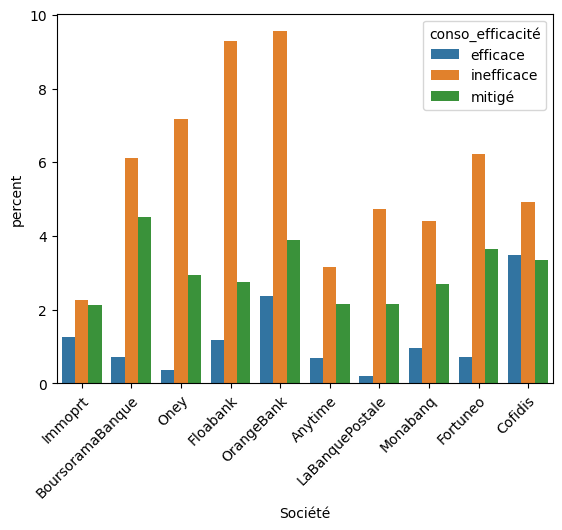

In [8]:
# top_bank topbank
list_top = [bank for bank in train.Société.value_counts().keys()[0:10]]
train_top = train[train['Société'].isin(list_top)]
train_top = train_top[train_top['conso_efficacité']!= "not discussed"]

import seaborn as sns
#plt.figure(figsize=(10,10))
sns.countplot(train_top, x = "Société", hue = "conso_efficacité", stat= "percent")
plt.xticks(rotation=45, ha = 'right', rotation_mode = "anchor");
plt.show()

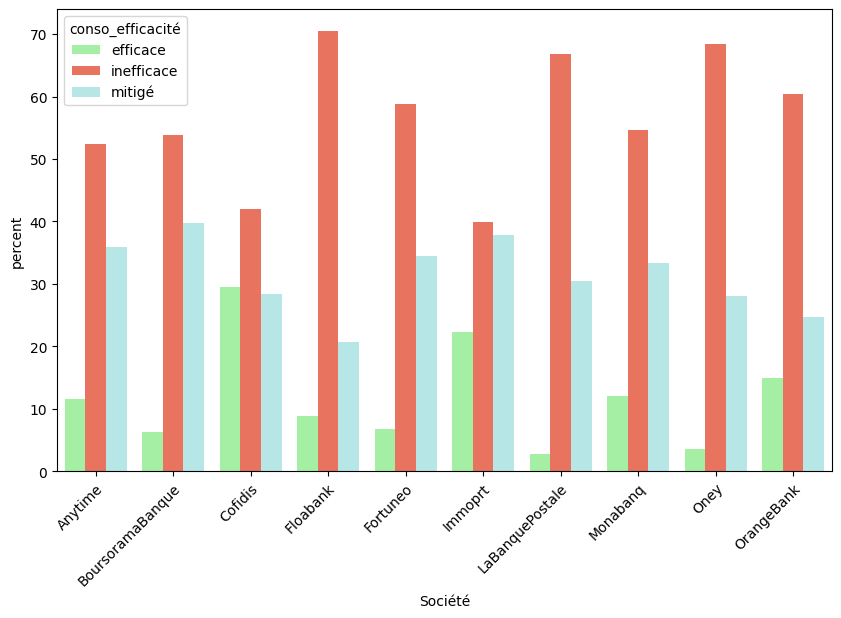

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

list_top = [bank for bank in train.Société.value_counts().keys()[0:10]]
train_top = train[train['Société'].isin(list_top)]
train_top = train_top[train_top['conso_efficacité']!= "not discussed"]

# Calculate the count for each combination of "Société" and "conso_efficacité"
count_df = train_top.groupby(['Société', 'conso_efficacité']).size().reset_index(name='count')

# Calculate the total count for each "Société"
total_count_df = train_top.groupby('Société')['conso_efficacité'].count().reset_index(name='total_count')

# Merge the count with the total count
merged_df = pd.merge(count_df, total_count_df, on='Société')

# Calculate the percentage for each "conso_efficacité" within each "Société"
merged_df['percent'] = (merged_df['count'] / merged_df['total_count']) * 100

palette = {
    "efficace": "palegreen",   # Greenish for 'efficace'
    "inefficace": "tomato",   # Redish for 'inefficace'
    "mitigé": "paleturquoise"       # Neutral for 'mitigé'
}

# % bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=merged_df, x='Société', y='percent', hue='conso_efficacité', palette=palette)
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.show()
